# ISI statistics

In [1]:
from imp import reload
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
import sys, os
import time
sys.path.append(os.path.abspath('../presentation')) # include path with style
sys.path.append(os.path.abspath('../simulation/')) # include path with simulation specifications
import pres_style as style; reload(style)

# Import specific moduls
#import network_params; reload(network_params)
import model_class; reload(model_class)
import sim_params as sim; reload(sim)
%matplotlib inline

show_fig = False
save_fig = True
picture_format = ".pdf"
xfactor = 2.6
style.rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83) 
figure_path = os.path.join(".", "figures")

reverse_order = True # do analysis such that plots resemble those of the paper (starting with L6i)
plotting = True

In [2]:
# DATA
data_file = "micro"
data_sup_path = "/export/data-schuessler/data_microcircuit/"
data_path = os.path.join(data_sup_path, data_file)
sim_spec = "a1.0_t300.2_totalN_00"

# Original data
file_name  = sim_spec + ".hdf5"  
res_file_name = sim_spec + "_res.hdf5"

### Basic data

In [3]:
# Open file: data
data_file = h5py.File(os.path.join(data_path, file_name), "r")

# Simulation attributes
area    = data_file.attrs["area"]   
t_sim   = data_file.attrs["t_sim"]  
t_trans = data_file.attrs["t_trans"]
dt      = data_file.attrs["dt"]    
populations   = data_file.attrs["populations"].astype("|U4")
layers        = data_file.attrs["layers"].astype("|U4")        
types         = data_file.attrs["types"].astype("|U4")     
n_populations = data_file.attrs["n_populations"]
n_layers      = data_file.attrs["n_layers"]       
n_types       = data_file.attrs["n_types"] 

t_measure = t_sim - t_trans


# labels & colors: need to be adapted if n_types != (e, i)
layer_colors = style.colors[:n_layers]
colors = np.array([color for color in layer_colors for i in range(n_types)])
colors[1::2] = colors[1::2] * 0.4   #### adapt for more than two types!
if reverse_order:
    populations = populations[::-1]
    layers = layers[::-1]
    types = types[::-1]
    colors = colors[::-1]
data_file.close()

## ISI distribution of single neuron

In [16]:
# neuron j of population i
i = 0 # population

bin_width = 0.01 # s
hist_max = 1. #s
n_bins_isi = int(hist_max / bin_width)
isi_bins = np.arange(0, hist_max, bin_width)


data_file = h5py.File(os.path.join(data_path, file_name), "r")
sim_spec2 = "0"
grp = data_file[sim_spec2 + "/spikes"]

population = populations[i]
subgrp = grp[str(population)]
raw_times_all   = subgrp["times"][:] * dt * 1e-3 # in seconds
indices         = subgrp["rec_neuron_i"][:]

j_max = 1
hist_isi = np.zeros((j_max, n_bins_isi))
for j in range(j_max):
    times = raw_times_all[indices[j]:indices[j+1]]
    times = times[times > t_trans]

    # isi histogram
    n_spikes = len(times)
    if n_spikes > 1:
        isi = np.diff(times)
        hist_isi[j] = np.histogram(isi, bins=n_bins_isi, range=(0, hist_max), density=True)[0]
        mean_isi = np.mean(isi)
        var_isi  = np.var(isi)
        cv_isi   = var_isi / mean_isi**2

data_file.close()

### Plotting

save figure to isi_single_histo_a1.0_t300.2_totalN_00_L6i.pdf


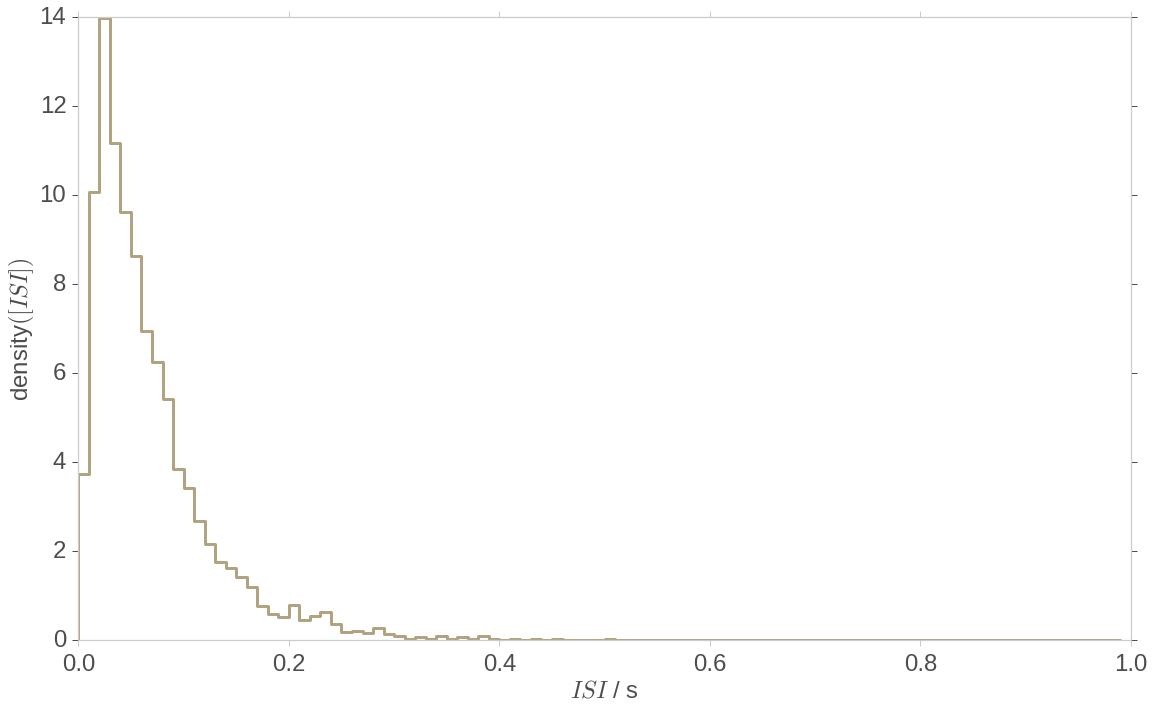

In [17]:
fig = plt.figure()
if not save_fig:
    suptitle = 'Simulation for: area = %.1f, time = %ims'%(area, t_sim)
    suptitle += '\nfile: ' + sim_spec
    fig.suptitle(suptitle, y=0.98)

# Histogram of membrane pot
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

i = np.where(population==populations)[0][0]
# Histograms
for j in range(j_max):
    ax1.plot(isi_bins, hist_isi[j], 
         linewidth=3., color=colors[j], alpha=0.5, drawstyle="steps")


# Histogram
ax1.set_ylabel('density$([ISI])$')
ax1.set_xlabel('$ISI$ / s')
ax1.set_xlim(0, hist_max)
#ax1.set_ylim(0, 0.15)
ax1.grid(False)
ax1.legend(loc=0)
    
for ax in fig.axes:
    style.fixticks(ax)
fig_name = "isi_single_histo_" + sim_spec

fig_name += "_" + population
fig_name += picture_format

if save_fig:
    print("save figure to " + fig_name)
    fig.savefig(os.path.join(figure_path,fig_name))

if show_fig:
    fig.show()

## ISI distribution of populations

In [18]:
bin_width = 0.01 # s
hist_max = 6. #s
n_bins_isi = int(hist_max / bin_width)
isi_bins = np.arange(0, hist_max, bin_width)
density_isi = np.zeros((n_populations, n_bins_isi))

data_file = h5py.File(os.path.join(data_path, file_name), "r")
grp = data_file[sim_spec2 + "/spikes"]

for i, population in enumerate(populations):
    subgrp = grp[str(population)]
    raw_times_all   = subgrp["times"][:] * dt * 1e-3 # in seconds
    indices         = subgrp["rec_neuron_i"][:]
        
    hist_isi_all = np.zeros(n_bins_isi)
    for j in range(len(indices) - 1):
        times = raw_times_all[indices[j]:indices[j+1]]
        times = times[times > t_trans]

        # isi histogram
        n_spikes = len(times)
        if n_spikes > 1:
            isi = np.diff(times)
            hist_isi_all += np.histogram(isi, bins=n_bins_isi, range=(0, hist_max), density=False)[0]
    
    density_isi[i] = hist_isi_all / (np.sum(hist_isi_all) * bin_width)
        
data_file.close()

save figure to isi_histo_a1.0_t300.2_totalN_00_0.pdf
save figure to isi_histo_a1.0_t300.2_totalN_00_1.pdf


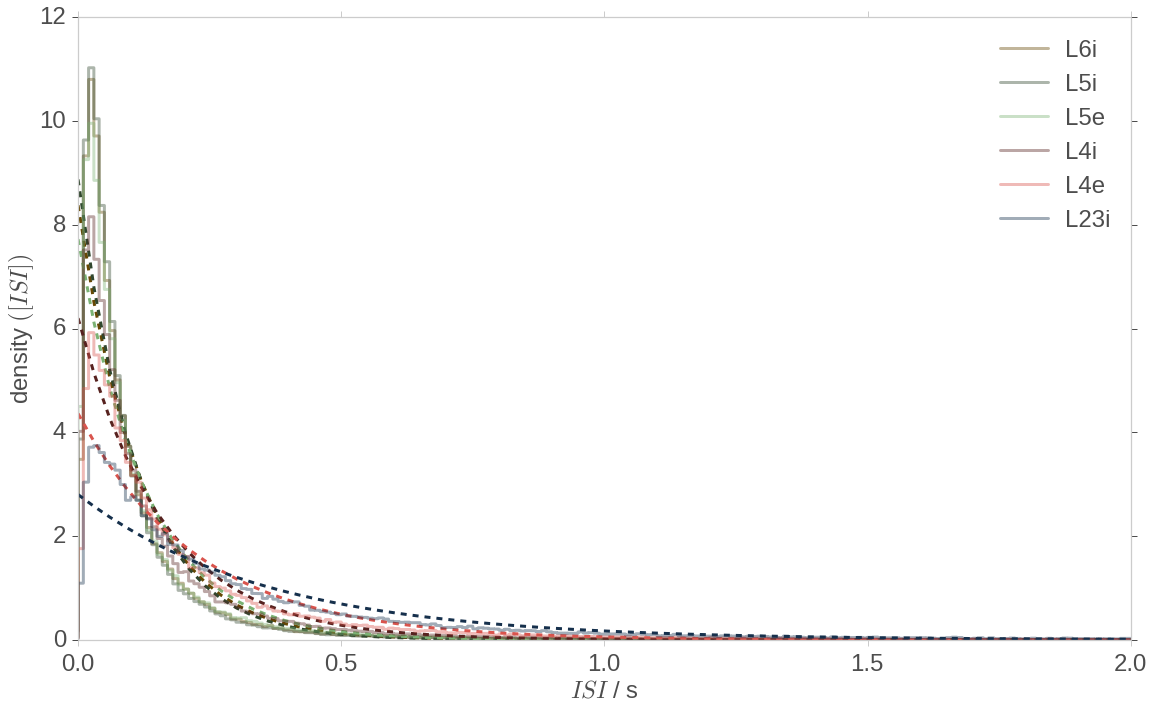

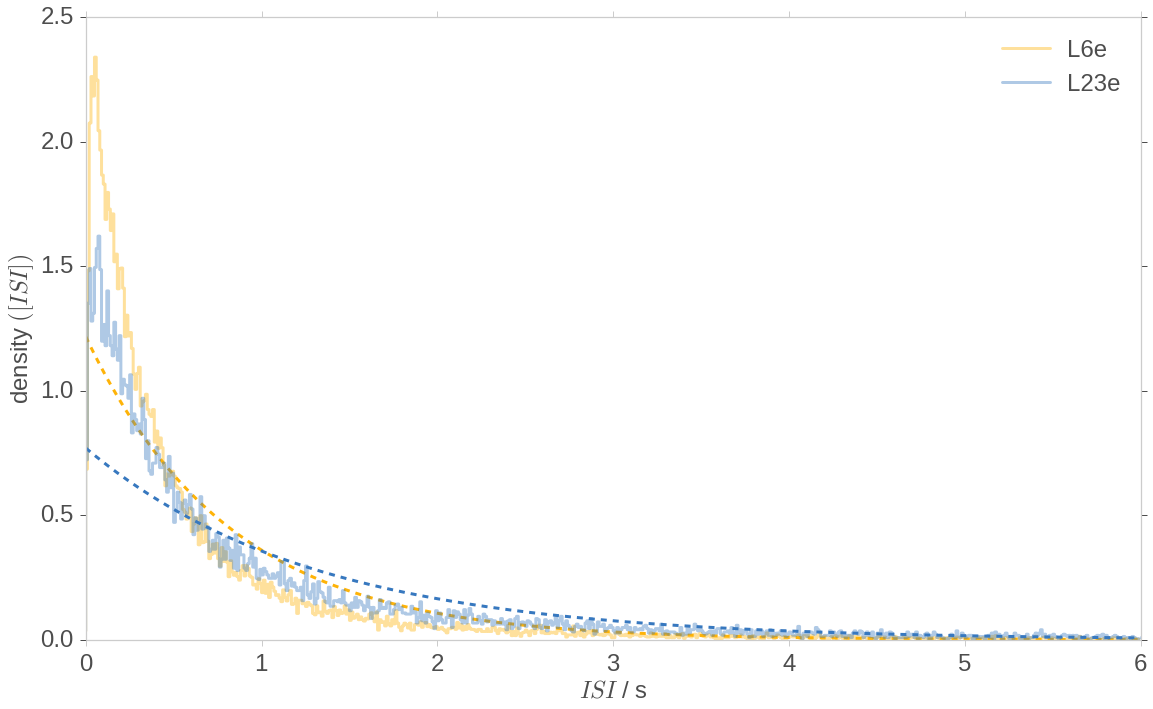

In [19]:
def density_theo(isi, rate):
    return(rate * np.exp(-rate * isi))
isi_cont = np.linspace(0, hist_max, 200)

fig0 = plt.figure()
fig1 = plt.figure()
all_figs = [fig0, fig1]
axs = []
gridspec=plt.GridSpec(1, 1)
subplotspec=gridspec.new_subplotspec((0, 0), rowspan=1, colspan=1)
for fig in all_figs:
    axs.append(fig.add_subplot(subplotspec))
ax0, ax1 = axs

for i, population in enumerate(populations):
    if (population != "L23e") and (population != "L6e"):
        ax0.plot(isi_bins, density_isi[i], 
                 linewidth=3., color=colors[i], alpha=0.4, drawstyle="steps", label=population)
        ax0.plot(isi_cont, density_theo(isi_cont, rates_mean[i]), "--", 
                 linewidth=3., color=colors[i])
    else:
        ax1.plot(isi_bins, density_isi[i], 
                 linewidth=3., color=colors[i], alpha=0.4, drawstyle="steps", label=population)
        ax1.plot(isi_cont, density_theo(isi_cont, rates_mean[i]), "--", 
                 linewidth=3., color=colors[i])

# Ranges
ax0.set_xlim(0, 2.)
ax1.set_xlim(0, 6.)

# Histograms
for ax in axs:
    ax.set_ylabel('density $([ISI])$')
    ax.set_xlabel('$ISI$ / s')
    ax.legend(loc="best")
    ax.grid(False)
    style.fixticks(ax)

for i, fig in enumerate(all_figs):
    fig_name = "isi_histo_" + sim_spec

    fig_name += "_" + str(i)
    fig_name += picture_format

    if save_fig:
        print("save figure to " + fig_name)
        fig.savefig(os.path.join(figure_path,fig_name))
    else:
        suptitle = 'Simulation for: area = %.1f, time = %ims'%(area, t_sim)
        suptitle += '\nfile: ' + sim_spec
        fig.suptitle(suptitle, y=0.98)

    if show_fig:
        fig.show()